In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import modal

In [2]:
path = "ses-01/anat/sub-HC001_ses-01_acq-inv1_T1map.nii"

In [3]:
img = nib.load(path).get_fdata()
img = np.asarray(img)
img.shape

(240, 320, 320)

In [4]:
#transfrom data
m = np.max(img)
new_img = np.ones((img.shape[2], img.shape[0], img.shape[1], 3))
for i in range(img.shape[2]):
    new_img[i] = np.stack((img[:, :, i], 0*img[:, :, i], 0*img[:, :, i]), axis=2)
new_img *= 1/m


In [27]:
img = img[:50, :50, :50]

In [ ]:
print(img[:, :, 110][:70, :70])

In [ ]:
plt.imshow(new_img[100, :, :])

In [ ]:
print(f"The .nii files are stored in memory as numpy's: {type(img)}.")

In [ ]:
for i in rnag

In [ ]:
plt.style.use('default')
fig, axes = plt.subplots(5,5, figsize=(12,12))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(img[:,:,1 + i], cmap="gray")
plt.show()

In [5]:
# fit n number of frame in single representation
# model: HashNeRF(t,x,y)
# future: t, HashNeRF(x,y) ?
import os
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import random
from pathlib import Path
from tqdm import tqdm
from timeit import default_timer as timer
print(torch.__version__)
torch.manual_seed(42)
np.random.seed(seed=42)
random.seed(42)
c_elegans = True


2.0.0


In [ ]:
H, W, T = 240, 320, 320
video_tensor = torch.rand(H, W, T)
print(video_tensor.shape)

In [6]:
print("Cuda available: ", torch.cuda.is_available())
if(torch.cuda.is_available()):
    torch.cuda.set_device("cuda:0")
    print("Is cuDNN version:", torch.backends.cudnn.version())
    print("cuDNN enabled:a", torch.backends.cudnn.enabled)
    print("Device count: ", torch.cuda.device_count())
    print("Current device: ", torch.cuda.current_device())
    print("Device name: ", torch.cuda.get_device_name(torch.cuda.current_device()))
#Setup device agnostic code (i.e use GPU if possible)
device = "cuda" if torch.cuda.is_available() else "cpu"
video = torch.tensor(img).to(device)
print(device)

Cuda available:  False
cpu


In [7]:
import math
from pathlib import Path
def PSNR(MSELoss, max):
    return (20*math.log10(max)) - (10*math.log10(MSELoss))

In [57]:

class hashNerf3D(nn.Module):
    def __init__(self,
                input_shape: int,  # Update to 3 for 3D coordinates
                hidden_units: int,
                output_shape: int,
                L=16, T=2**18, F=2, N_min=8, N_max=256, num_output=1):
        self.L = L
        self.T = T
        self.F = F
        self.N_min = N_min
        self.N_max = N_max
        self.num_output = num_output
        super().__init__()

        b = np.exp((np.log(self.N_max) - np.log(self.N_min)) / (self.L - 1)) # scalar : dim 1
        self.N_values = torch.floor(torch.tensor(np.float32(self.N_min * b ** np.arange(self.L)))).type(torch.int64).to(device) # dim : 16,1
        temp_hash_table = torch.FloatTensor(L,T,F).uniform_(-1e-4, 1e-4) # dim : L, T, F
        self.hash_table = nn.Parameter(torch.tensor(temp_hash_table.clone(), requires_grad=True).to(device).type(torch.float32))
        self.vertices = torch.transpose(torch.tensor([
                        [0, 0, 0],
                        [0, 0, 1],
                        [0, 1, 0],
                        [0, 1, 1],
                        [1, 0, 0],
                        [1, 0, 1],
                        [1, 1, 0],
                        [1, 1, 1]]), 0, 1).type(torch.float32).to(device) 
        self.prime_numbers = torch.tensor([1, 2654435761, 805459861]).type(torch.int64).to(device)

        self.layer_stack = nn.Sequential(
            nn.Linear(input_shape, hidden_units),
            nn.LeakyReLU(),
            nn.Linear(hidden_units, output_shape),
            nn.ReLU()
        ).to(device)

    def forward(self, X):
        X = X.to(device)
        ##print("X shape:", X.shape)
        x_scaled = X[:, :, None] * self.N_values[None, None, :]
        #print("x_scaled shape:", x_scaled.shape)
        x_floor = torch.floor(x_scaled)
        #print("x_floor shape:", x_floor.shape)
        x_ceil = torch.ceil(x_scaled)
        #print("x_ceil shape:", x_ceil.shape)
        #x_vertices = torch.zeros((len(x_floor), 3, self.L, 8)).to(device)
        #print("x_vertices shape:", x_vertices.shape)
        x_vertices = x_floor[:, :, :, None] * self.vertices[None, :, None, :]
        #print("x_vertices updated shape:", x_vertices.shape)
        x_vertices = x_vertices.type(torch.int64)
        
        primesTemp = torch.tensor([1, 2654435761, 805459861]).type(torch.int64).to(device)
        x_to_hash_temp = x_vertices * primesTemp[None, :, None, None]
        #print("x_to_hash_temp shape:", x_to_hash_temp.shape)

        x_hash_temp = torch.bitwise_xor(
                        torch.bitwise_xor(x_to_hash_temp[:, 0],
                                            x_to_hash_temp[:, 1]),
                            x_to_hash_temp[:, 2])
        #print("x_hash_temp shape:", x_hash_temp.shape)
        x_hash_temp = torch.remainder(x_hash_temp, self.T) 
        x_hash = x_hash_temp
        #print("x_hash shape:", x_hash.shape)
        x_hash = x_hash.to(device)
        x_hash = x_hash.permute(1, 0, 2)
        #print("x_hash permuted shape:", x_hash.shape)
        lookup = torch.stack([self.hash_table[i][x_hash[i]] for i in range(self.L)], dim=0).to(device)
        #print("lookup shape:", lookup.shape)
        lookup = lookup.permute(1,0,2,3)
        #print("lookup permuted shape:", lookup.shape)
        
        weights = x_scaled - x_floor
        #print("weights shape:", weights.shape)
        fx = weights[:, 0, :]
        cx = 1 - fx
        fy = weights[:, 1, :]
        cy = 1 - fy
        fz = weights[:, 2, :]
        cz = 1 - fz
        
        f111 = fx * fy * fz  
        f110 = fx * fy * cz
        f101 = fx * cy * fz
        f100 = fx * cy * cz
        f011 = cx * fy * fz
        f010 = cx * fy * cz
        f001 = cx * cy * fz
        f000 = cx * cy * cz
        f_stack = torch.stack([f000, f001, f010, f011, f100, f101, f110, f111], dim=2)
        #print("f_stack shape:", f_stack.shape)
        x_interp = torch.sum(f_stack[:, :, :, None] * lookup, dim=2)
        #print("x_interp shape:", x_interp.shape)
        x = x_interp.reshape(-1, self.L * self.F)
        #print("x shape after reshape:", x.shape)
        
        return self.layer_stack(x.to(device).type(torch.float32))

  

In [58]:
# Data Loader
class MultiImageDataset(Dataset):
    def __init__(self, video_tsr, s, e, transform=None, target_transform=None):
        self.video = video_tsr[s:e].type(torch.float32)
        self.transform = transform
        self.target_transform = target_transform
        self.s = s
        self.e = e
    def __len__(self):
        return self.video.shape[0] * self.video.shape[1] * self.video.shape[2]
    def __getitem__(self, idx):
        f = 1.0 * idx // (self.video.shape[1] * self.video.shape[2])
        r = idx % (self.video.shape[1] * self.video.shape[2])
        row = r // self.video.shape[2]
        col = r % self.video.shape[2]
        image = self.video[int(f)]
        #label = pixel 
        pixel = torch.as_tensor(image[int(row)][int(col)]).type(torch.float32).to(device)
        row = row / (image.shape[0])
        col = col / (image.shape[1])
        return torch.as_tensor([f / len(video), row, col]).type(torch.float32).to(device), pixel


In [ ]:
k = 20 # num of frames to fit per NeRF
v_start = 90
v_end = 95
model_0 = hashNerf3D(32, 128, 3)

In [60]:
training_data = MultiImageDataset(torch.tensor(new_img), v_start, v_end)
train_loader = DataLoader(training_data, batch_size=2**18, shuffle=True)
#params



In [61]:
lr1 = 0.01
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=lr1, eps=10e-15)
# Training Loop

In [ ]:
for epoch in tqdm(range(0, 40)):
    model_0.train()
    for batch in iter(train_loader):
        y_train = torch.as_tensor(batch[1]).to(device)
        y_train = torch.squeeze(y_train)
        X = torch.tensor(batch[0]).type(torch.float32)
        y_train = torch.as_tensor(y_train).type(torch.float32)
        # Forward Pass
        y_pred = model_0(X).type(torch.float32)
        loss = loss_fn(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if loss == 0:
        print("done")
    psnr = PSNR(loss, 1.0)
    if epoch % 1 == 0:
        print(f"Epoch: {epoch} | LR: {lr1} | Train loss: {loss} | PSNR: {psnr}")

In [ ]:
f = 10
x_test_T = torch.as_tensor(new_img[100])
gif_reconstruct_mat = np.empty((f, new_img.shape[1], new_img.shape[2], 3)).astype(np.uint8)
#encode coordinates into debug matrix
for t in range(0, 10):
    for i in range(0, x_test_T.shape[0]):
        for j in range(0, x_test_T.shape[1]):
            x_test_T[i][j] = torch.as_tensor([(t+90)/new_img.shape[0], i/(video.shape[1]-0),j/(video.shape[2]-0)]).type(torch.float32)
    reconstruction_input_matrix = torch.flatten(x_test_T, 0, 1)

    model_0.eval()
        
    with torch.inference_mode():
        reconstruction = model_0(reconstruction_input_matrix).cpu()
        reconstruction = reconstruction.reshape((new_img[100].shape[0], new_img[100].shape[1], 3))
        reconstruction = torch.stack((reconstruction[:, :, 0], reconstruction[:, :, 0], reconstruction[:, :, 0]), axis=2)
        reconstruction = (255*reconstruction).type(torch.uint8)
        #reconstruction = torch.mul(255, reconstruction).type(torch.int32)
        gif_reconstruct_mat[t] = reconstruction.numpy()
        plt.axis(False)
        plt.title('frame: ' + str(t))
        plt.imshow(reconstruction)
        plt.savefig(f"{t}.jpg", bbox_inches = "tight")
        #plt.savefig("c_elegans_reconstructions_3D/hash_nerf_3D_DEBUG_reconstruction_frame_"+str(t)+ ".png", bbox_inches="tight", pad_inches=0.0)
       


In [ ]:
plt.imshow(reconstruction[:, :, )])

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class GaussianSplatting3D(nn.Module):
    def __init__(self, grid_size, num_gaussians):
        super(GaussianSplatting3D, self).__init__()
        
        self.grid_size = grid_size
        self.num_gaussians = num_gaussians
        
        # Means for each Gaussian in 3D space
        self.mu = nn.Parameter(torch.randn(num_gaussians, 3))  # Means in 3D space
        # Standard deviations (sigma) for each Gaussian along each axis
        self.sigma = nn.Parameter(torch.rand(num_gaussians, 3) * 0.1)  # Initialize small

        # Amplitudes of the Gaussians
        self.amplitude = nn.Parameter(torch.rand(num_gaussians))

    def gaussian_kernel(self, x, mu, sigma):
        return torch.exp(-0.5 * ((x - mu) / sigma) ** 2)

    def forward(self, grid):
        # Flatten the grid to [H*W*T, 3] for batch processing
        grid_flat = grid.view(-1, 3)  # [H*W*T, 3]
        result = torch.zeros(grid_flat.size(0)).to(grid.device)
        
        # Iterate over all Gaussians
        for i in range(self.num_gaussians):
            # Compute Gaussian splat for each point in the grid
            dist = self.gaussian_kernel(grid_flat, self.mu[i], self.sigma[i])
            dist_prod = torch.prod(dist, dim=-1)  # Product across dimensions (x, y, z)
            
            # Accumulate weighted by the amplitude
            result += self.amplitude[i] * dist_prod

        return result.view(self.grid_size)  # Reshape to original 3D grid size

In [ ]:
!modal token new

In [ ]:
!modal volume create nii-vol

In [ ]:
!modal volume put nii-vol sub-HC001_ses-01_acq-inv1_T1map.nii

In [ ]:
image = modal.Image.debian_slim().pip_install("nibabel", "torch", "matplotlib", "numpy", "tqdm", "imageio").pip_install("torchvision")

volume = modal.Volume.from_name("nii-vol")

app = modal.App()
v = {"/data": volume}
@app.function(image=image, volumes=v)
def mr():
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import numpy as np
    import modal
    from modal import app

    class GaussianSplatting3D(nn.Module):
        def __init__(self, grid_size, num_gaussians):
            super(GaussianSplatting3D, self).__init__()
            
            self.grid_size = grid_size
            self.num_gaussians = num_gaussians
            
            # Means for each Gaussian in 3D space
            self.mu = nn.Parameter(torch.randn(num_gaussians, 3))  # Means in 3D space
            # Standard deviations (sigma) for each Gaussian along each axis
            self.sigma = nn.Parameter(torch.rand(num_gaussians, 3) * 0.1)  # Initialize small

            # Amplitudes of the Gaussians
            self.amplitude = nn.Parameter(torch.rand(num_gaussians))

        def gaussian_kernel(self, x, mu, sigma):
            return torch.exp(-0.5 * ((x - mu) / sigma) ** 2)

        def forward(self, grid):
            # Flatten the grid to [H*W*T, 3] for batch processing
            grid_flat = grid.view(-1, 3)  # [H*W*T, 3]
            result = torch.zeros(grid_flat.size(0)).to(grid.device)
            
            # Iterate over all Gaussians
            for i in range(self.num_gaussians):
                # Compute Gaussian splat for each point in the grid
                dist = self.gaussian_kernel(grid_flat, self.mu[i], self.sigma[i])
                dist_prod = torch.prod(dist, dim=-1)  # Product across dimensions (x, y, z)
                
                # Accumulate weighted by the amplitude
                result += self.amplitude[i] * dist_prod

            return result.view(self.grid_size)  # Reshape to original 3D grid size
    # Generate dummy video data (random tensor)
    H, W, T = img.shape[0], img.shape[1], img.shape[2]  # Dimensions of the video
    video_tensor = img.type(torch.float32)

    # Create 3D grid for Gaussian splatting
    x = torch.linspace(0, 1, H)
    y = torch.linspace(0, 1, W)
    z = torch.linspace(0, 1, T)
    X, Y, Z = torch.meshgrid(x, y, z)
    grid = torch.stack([X, Y, Z], dim=-1)  # Create a 3D grid of shape [H, W, T, 3]

    # Instantiate GaussianSplatting3D
    num_gaussians = 100 # Number of Gaussians
    model = GaussianSplatting3D((H, W, T), num_gaussians)

    # Define loss and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Training loop
    num_epochs = 100
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # Forward pass: Apply the splatting to the grid
        output = model(grid)
        
        # Compute loss (comparison to original video tensor)
        loss = criterion(output, video_tensor)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        if (epoch) % 1 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

with app.run():
    result = mr.remote()

In [ ]:
pre_img = nib.load(path).get_fdata()
pre_img = np.asarray(pre_img)

img = torch.tensor(pre_img / np.max(pre_img))
print(img)

In [ ]:
# Generate dummy video data (random tensor)
H, W, T = img.shape[0], img.shape[1], img.shape[2]  # Dimensions of the video
video_tensor = img.type(torch.float32)

# Create 3D grid for Gaussian splatting
x = torch.linspace(0, 1, H)
y = torch.linspace(0, 1, W)
z = torch.linspace(0, 1, T)
X, Y, Z = torch.meshgrid(x, y, z)
grid = torch.stack([X, Y, Z], dim=-1)  # Create a 3D grid of shape [H, W, T, 3]

# Instantiate GaussianSplatting3D
num_gaussians = 500 # Number of Gaussians
model = GaussianSplatting3D((H, W, T), num_gaussians)

# Define loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Forward pass: Apply the splatting to the grid
    output = model(grid)
    
    # Compute loss (comparison to original video tensor)
    loss = criterion(output, video_tensor)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if (epoch) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


In [ ]:
plt.imshow(model(grid).detach().numpy()[:, :, 5], cmap="gray")

In [14]:
test_img = np.stack((torch.eye((20)), torch.eye((20)), torch.eye((20)), torch.eye((20)), torch.eye((20))), axis=2).astype(np.float32)

In [34]:
test_img_2 = np.stack(((new_img[0])[:, :, 0], (new_img[1])[:, :, 0], (new_img[2])[:, :, 0], (new_img[3])[:, :, 0]), axis=2).astype(np.float32)

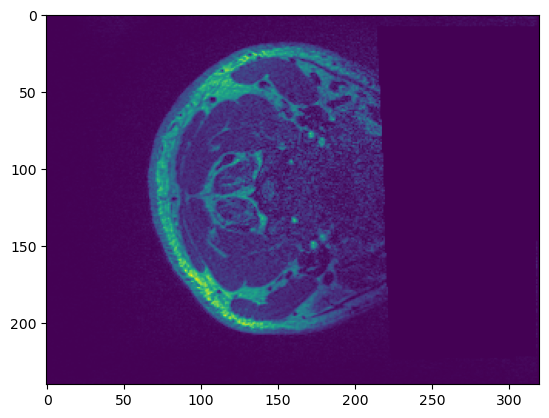

In [31]:
plt.imshow((new_img[0])[:, :, 0])

In [32]:
test_img_2.shape

(240, 320, 4)

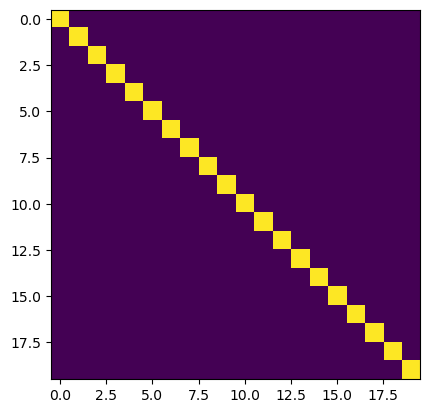

In [18]:
plt.imshow(test_img[:, :, 0])

In [59]:
# Generate dummy video data (random tensor)
H, W, T = test_img_2.shape[0], test_img_2.shape[1], test_img_2.shape[2] # Dimensions of the video
video_tensor = torch.tensor(test_img_2).type(torch.float32)

# Create 3D grid for Gaussian splatting
x = torch.linspace(0, 1, H)
y = torch.linspace(0, 1, W)
z = torch.linspace(0, 1, T)
X, Y, Z = torch.meshgrid(x, y, z, indexing='ij')  # Use 'ij' indexing for compatibility
grid = torch.stack([X, Y, Z], dim=-1)  # Create a 3D grid of shape [H, W, T, 3]

# Instantiate GaussianSplatting3D
num_gaussians = 5000 # Number of Gaussians
model = GaussianSplatting3D((H, W, T), num_gaussians)



In [60]:
# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, eps=10e-15)

In [61]:
# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Forward pass: Apply the splatting to the grid
    output = model(grid)
    
    # Compute loss (comparison to original video tensor)
    loss = criterion(output, video_tensor)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if (epoch) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.0573
Epoch [2/100], Loss: 0.0192
Epoch [3/100], Loss: 0.0113
Epoch [4/100], Loss: 0.0088
Epoch [5/100], Loss: 0.0074
Epoch [6/100], Loss: 0.0065


KeyboardInterrupt: 

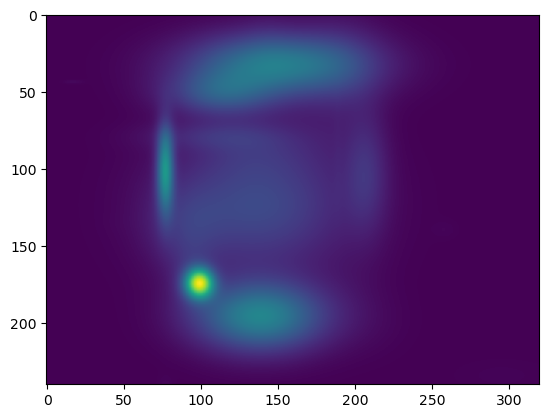

In [63]:
plt.imshow(model(grid).detach().numpy()[:, :, 3])